In [1]:
import sys
sys.path.append('/home/idnm/Programming projects/jax_circuits/')

from jax_circuits import *
from exact_decompositions import *
from cp_utils import *
from qiskit import transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford
from qiskit.extensions import UnitaryGate

from scipy.stats import unitary_group
from fractions import Fraction


plt.rcParams.update({'font.size': 14})

To do

1. Local minima plots in an accurate way:
    1. For each ansatz several random unitaries and several self-unitaries. 
    1. Separately stats for different realizations of Toffoli 3 and Toffoli 4 gates.

# Local minimums

## Empirical success ratio: definition and example

In [7]:
anz = Ansatz(3, 'cp', fill_layers(connected_layer(3), 3))
anz.circuit().draw(output='mpl')
print(anz.circuit().draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_Z}\,(\mathrm{a_{0}})} & \gate{\mathrm{R_X}\,(\mathrm{a_{1}})} & \gate{\mathrm{R_Z}\,(\mathrm{a_{2}})} & \ctrl{1} & \dstick{\hspace{2.0em}\mathrm{P}\,(\mathrm{a_{15}})} \qw & \qw & \qw & \gate{\mathrm{R_X}\,(\mathrm{a_{9}})} & \gate{\mathrm{R_Y}\,(\mathrm{a_{11}})} & \gate{\mathrm{R_Z}\,(\mathrm{a_{13}})} & \ctrl{2} & \qw & \qw & \qw & \gate{\mathrm{R_X}\,(\mathrm{a_{16}})} & \gate{\mathrm{R_Y}\,(\mathrm{a_{18}})} & \gate{\mathrm{R_Z}\,(\mathrm{a_{20}})} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_Z}\,(\mathrm{a_{3}})} & \gate{\mathrm{R_X}\,(\mathrm{a_{4}})} & \gate{\mathrm{R_Z}\,(\mathrm{a_{5}})} & \control \qw & \qw & \qw & \qw & \gate{\mathrm{R_X}\,(\mathrm{a_{10}})} & \gate{\math

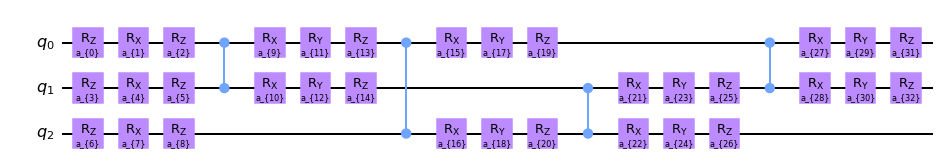

In [50]:
anz = Ansatz(3, 'cz', fill_layers(connected_layer(3), 4))
target_angles = random_angles(anz.num_angles)
target_circuit = anz.circuit(target_angles)
target_unitary = anz.unitary(target_angles)

anz.circuit().draw(output='mpl')

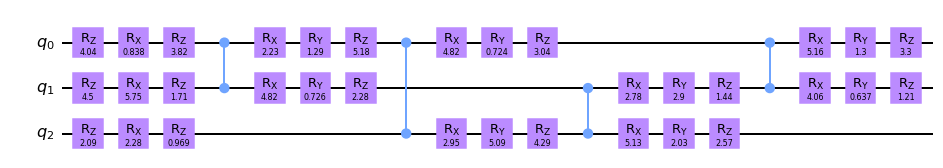

In [36]:
target_circuit.draw(output='mpl')

Success ratio of our default optimization procedure:

In [37]:
results = anz.learn(
    target_unitary, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=100)

success_record = [jnp.min(r['loss'])<1e-4 for r in results]
sr = sum(success_record)/len(success_record)
print(f'Success Ratio is {sr}')

Success Ratio is 0.3100000023841858


## 3q chart

In [48]:
def mean_and_std(results):
    mean_list = []
    std_list = []
    for i in range(len(results[0])):
        sr_list = jnp.array([res[i]['success_ratio'] for res in results])
        mean_list.append(jnp.mean(sr_list))
        std_list.append(jnp.std(sr_list))
    
    return mean_list, std_list        

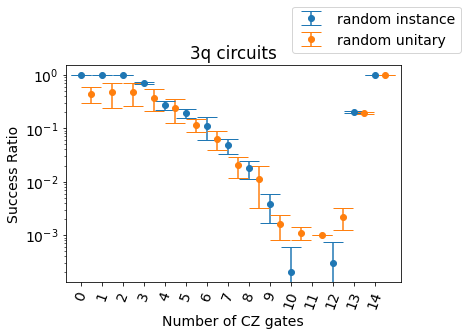

In [49]:
results_self = []
for i in range(10):
    with open(f'results/xyz/3q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'results/xyz/3q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)
plt.errorbar(range(len(mean_list_self)), mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(jnp.arange(len(mean_list_unitary))+0.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')

plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.yscale('log')
plt.xticks(range(len(mean_list_self)), rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('3q circuits')
plt.savefig('figures/3q_success_chart', dpi=1000, bbox_inches='tight')

## 4q chart

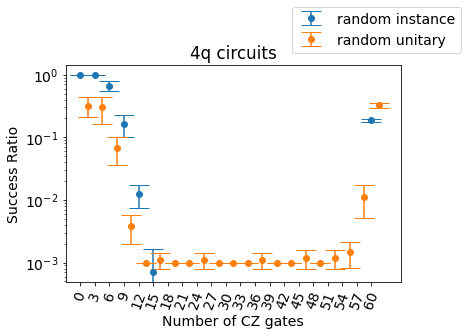

In [89]:
results_self = []
for i in range(10):
    with open(f'data/local_minimums/4q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'data/local_minimums/4q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

xticks = jnp.arange(theoretical_lower_bound(4)+1)[::3]
plt.errorbar(xticks, mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(xticks+1.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.xlim([-3, 66])
plt.yscale('log')
plt.xticks(xticks, rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('4q circuits')
plt.savefig('figures/4q_success_chart', dpi=1000, bbox_inches='tight')        

# CPFlow

## Main ideas

$CP$-templates.

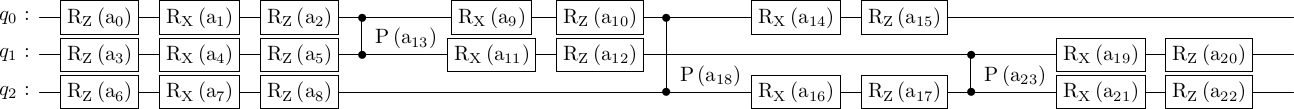

In [100]:
anz = Ansatz(3, 'cp', fill_layers(connected_layer(3),3))
anz.circuit().draw(output='latex')

Regularization function.

In [131]:
RegularizationOptions()

RegularizationOptions(function='linear', ymax=2, xmax=1.5707963267948966, plato_0=0.05, plato_1=0.05, plato_2=0.05)

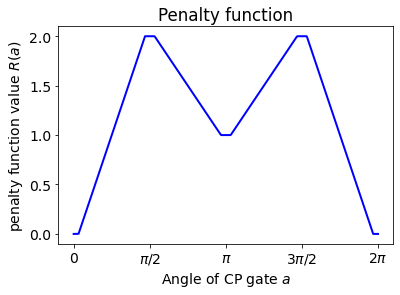

In [135]:
regularization_options = RegularizationOptions(plato_0=0.1, plato_1=0.1, plato_2=0.1)
regularization_func = make_regularization_function(regularization_options)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)

plt.plot(a_sweep, vmap(regularization_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')
plt.savefig('figures/penalty', dpi=1000, bbox_inches='tight')        

# Toffoli

## Toffoli 3

### Connected

Optimal hyperparameters: k=7, r=0.0013153787719205608
Optimal decompositions (out of 100): 28


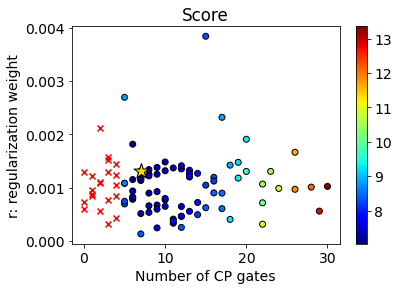

In [21]:
results = Results.load('results/toff3_conn_xyz')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==6]
print(f'Optimal hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_conn', dpi=1000, bbox_inches='tight')        

Best circuits in each nomination. The circuit with the best $T$-depth is simultaneously the winner in all other nominations.

In [28]:
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

best_decomposition = best_t_depth_decomposition

print(best_cz_count_decomposition)
print(best_cz_depth_decomposition)
print(best_t_count_decomposition)
print(best_t_depth_decomposition)

< toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
< toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
< toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
< toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 4 >


This circuit won the appearance in the paper.

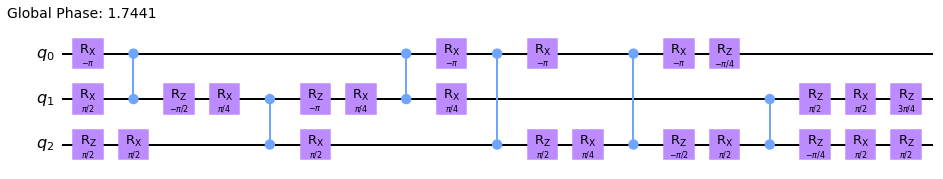

In [29]:
best_decomposition.circuit.draw(output='mpl')

### Chain

Optimal hyperparameters: k=14, r=0.000882908121237346
Optimal decompositions (out of 100): 19


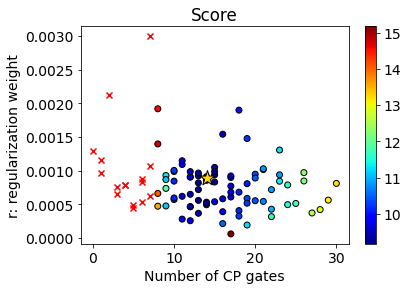

In [42]:
results = Results.load('results/toff3_chain_xyz')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==8]
print(f'Optimal hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_chain', dpi=1000, bbox_inches='tight')        

Again, the best overall decomposition turns out to be the onewith the smallest $T$-depth.

In [46]:
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

best_decomposition = best_t_depth_decomposition

print(best_cz_count_decomposition)
print(best_cz_depth_decomposition)
print(best_t_count_decomposition)
print(best_t_depth_decomposition)

< toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
< toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
< toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
< toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 3 >


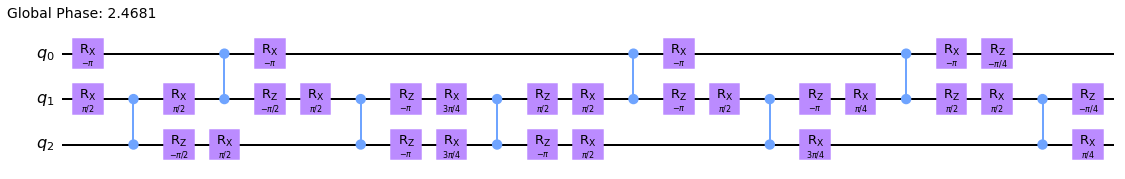

In [15]:
qc = best_decomposition.circuit
qc.draw(output='mpl')

## Toffoli 4

### Connected

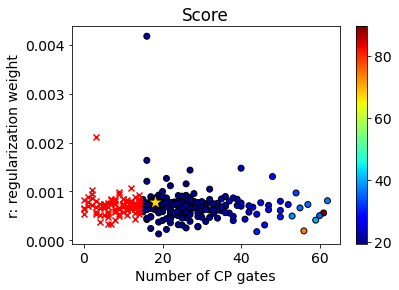

In [12]:
results = Results.load('results/toff4_conn_xyz')
d = results.decompositions[-1]
results.plot_trials()

< toff4_conn_xyz| Rational | loss: 2.384185791015625e-07  | CZ count: 14 | CZ depth: 11  >


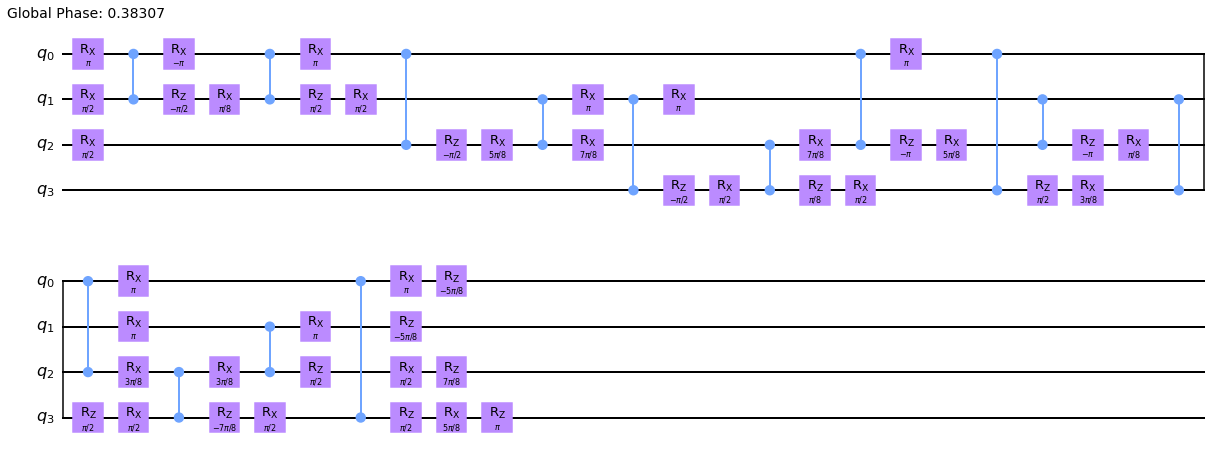

In [13]:
# d.refine()
print(d)
d.circuit.draw(output='mpl')

### Kite

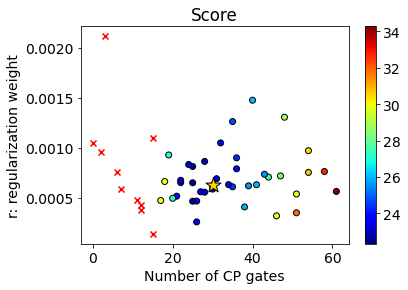

In [14]:
results = Results.load('results/toff4_kite_xyz')
results.plot_trials()

< toff4_kite_xyz| Rational | loss: 1.1920928955078125e-07  | CZ count: 14 | CZ depth: 13  >


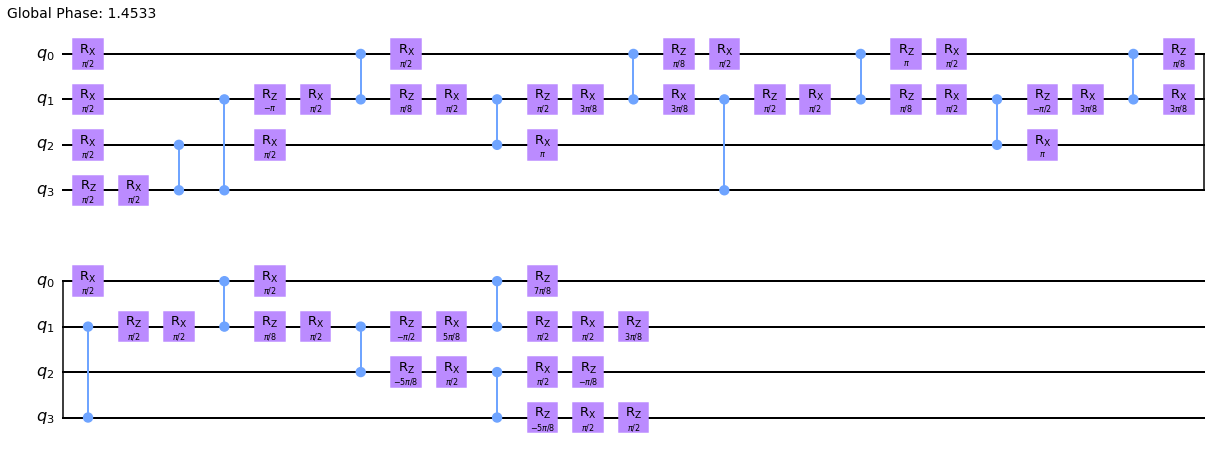

In [15]:
d = results.decompositions[-1]
# d.refine()
print(d)
d.circuit.draw(output='mpl')

### Square

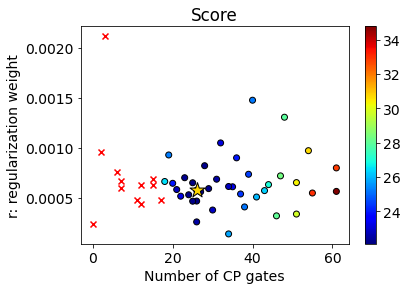

In [16]:
results = Results.load('results/toff4_square_xyz')
results.plot_trials()

< toff4_square_xyz| Rational | loss: 1.1920928955078125e-07  | CZ count: 16 | CZ depth: 15  >


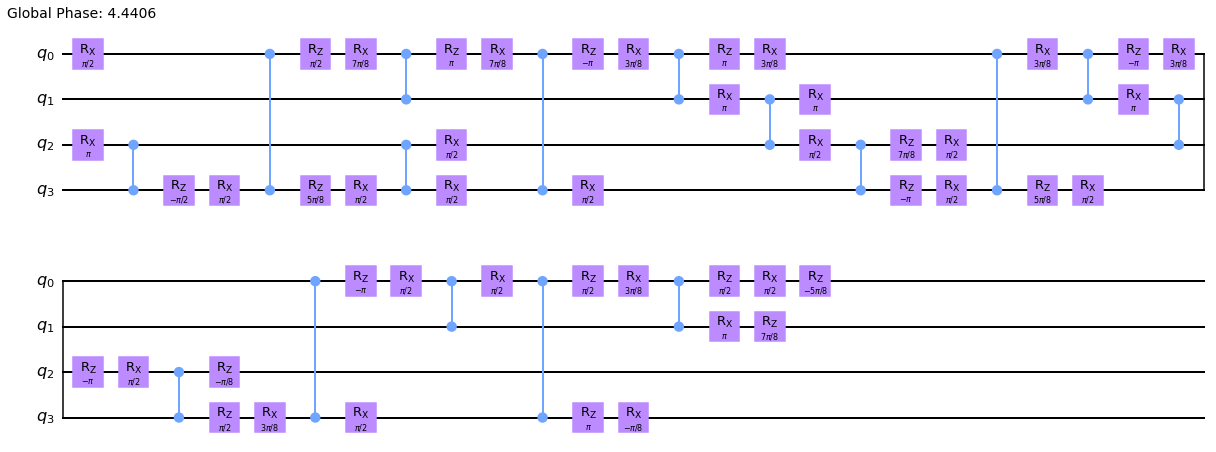

In [17]:
d = results.decompositions[-1]
# d.refine()
print(d)
d.circuit.draw(output='mpl')

### Star

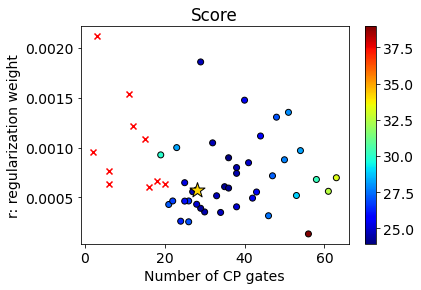

In [19]:
results = Results.load('results/toff4_star_xyz')
results.plot_trials()

In this case our automated procedure failed to make all angles rational.

In [21]:
d = results.decompositions[-1]
# d.refine(angle_threshold=0.1)
print(d)

< toff4_star_xyz| Approximate | loss: 0.0  | CZ count: 16 | CZ depth: 16  >


Here is a quick and dirty workaround manually rounding off gate angles.

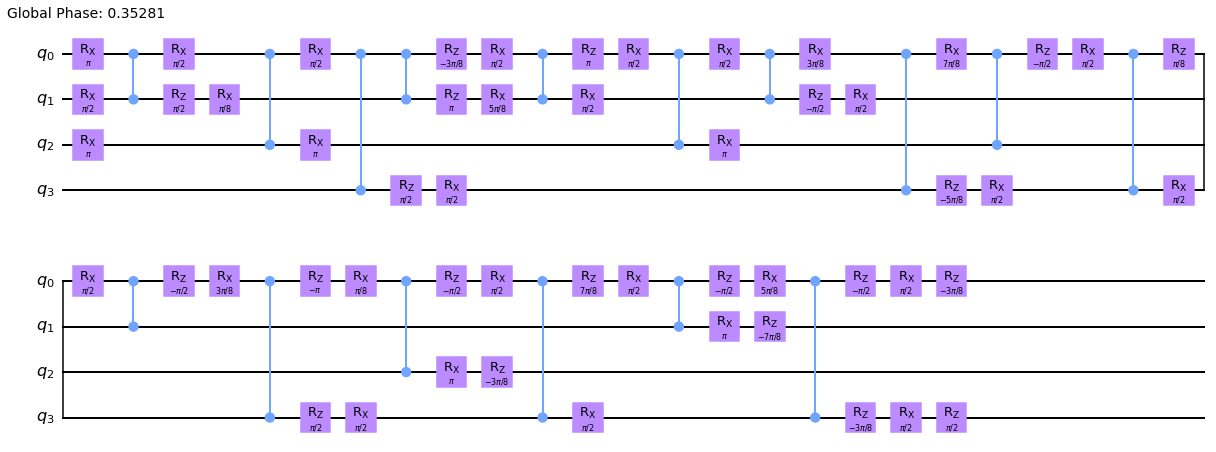

In [27]:
qx = d.circuit.copy()

new_data = []
for gate, qargs, cargs in qx.data:
    if gate.name in ['rx', 'ry', 'rz']:
        new_gate = gate
        angle = bracket_angle(gate.params[0])
        new_gate.params = [jnp.pi * Fraction.from_float(angle/jnp.pi).limit_denominator(8)]
    else:
        new_gate = gate
    new_data.append((gate, qargs, cargs))

qx.data = new_data
qx = remove_zero_rgates(qx)
qx.draw(output='mpl')

Let's check that the resulting circuit is indeed a good approximation of Toffoli 4.

In [28]:
cost_HST(Operator(qx.reverse_bits()).data, u_toff4)

DeviceArray(0., dtype=float32)

In [50]:
qx_0 = qx.copy()
qx_1 = qx.copy()

split = 36

qx_0.data = qx.data[:split]
qx_1.data = qx.data[split:]

print(cost_HST(Operator(qx).data, Operator(qx_0.compose(qx_1)).data))

1.1920929e-07


### Chain

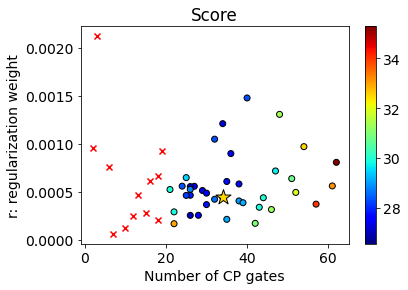

In [29]:
results = Results.load('results/toff4_chain_xyz')
results.plot_trials()

< toff4_chain_xyz| Rational | loss: 0.0  | CZ count: 18 | CZ depth: 14  >


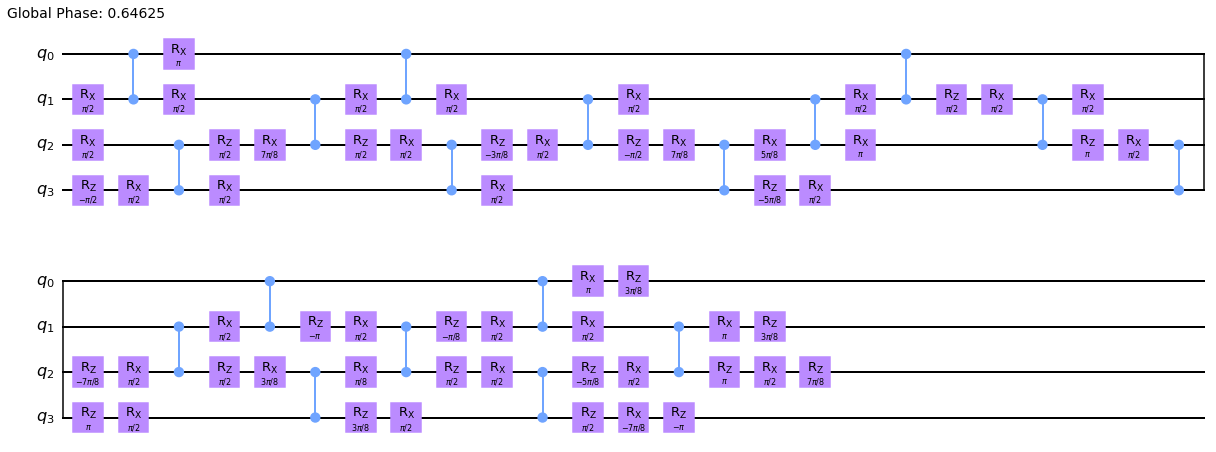

In [30]:
d = results.decompositions[-1]
# d.refine()
print(d)
d.circuit.draw(output='mpl')

## Toffoli 5

In [72]:
results = Results.load('results/toff4_relative_chain')

In [73]:
d = results.decompositions[-1]
d.refine(angle_threshold=0.1)

'Refined to Approximate'

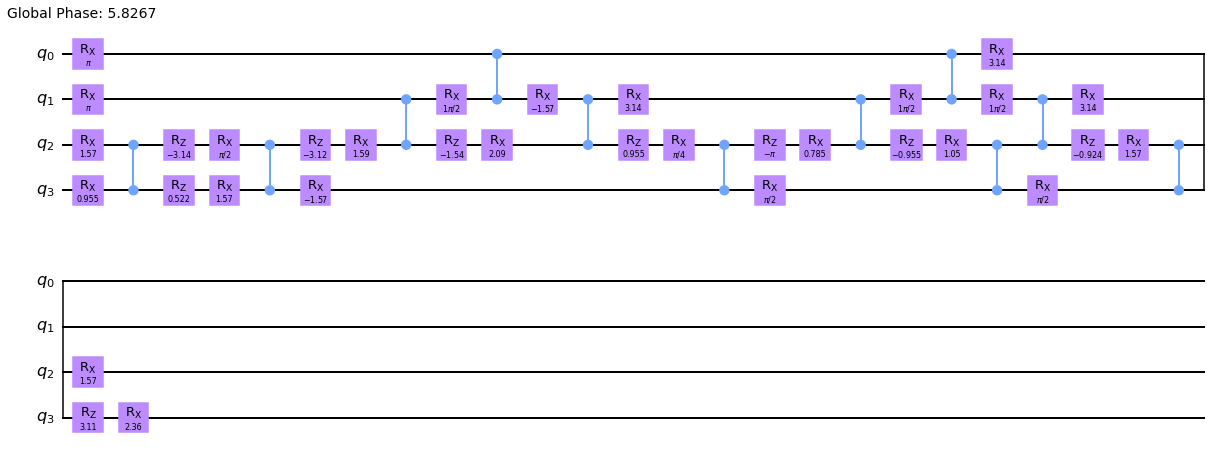

In [76]:
d.circuit.draw(output='mpl')

In [77]:
u_toff4_relative = d.unitary
qc = QuantumCircuit(4)
qc.append(UnitaryGate(u_toff4_relative), [0, 1, 2, 3])

g_toff_4_relative = qc.reverse_bits().to_instruction(label='RT4')
g_toff_4_relative.name = 'RT4'

Partially analytic decompositions that gives the optimal CZ count on the fully connected topology.

True


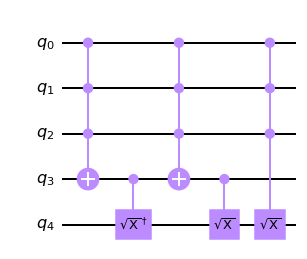

In [78]:
qc = QuantumCircuit(5)
qc.mct([0,1,2], 3)
qc.append(SXGate().inverse().control(1), [3,4])
qc.mct([0,1,2], 3)
qc.append(SXGate().control(1), [3,4])
qc.append(SXGate().control(3), [0,1,2,4])
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5))
qc.draw(output='mpl')

Adaptation of the above decomposition to the chain topology with synthesized relative Toffoli 4 gate.

0.0
True


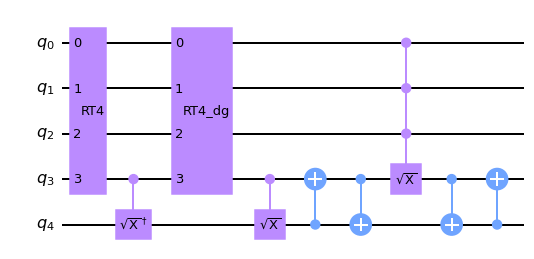

In [83]:
qc = QuantumCircuit(5)
qc.append(g_toff_4_relative, [0, 1, 2, 3])
qc.append(SXGate().inverse().control(1), [3,4])
qc.append(g_toff_4_relative.inverse(), [0, 1, 2, 3])

qc.append(SXGate().control(1), [3,4])

qc.cx(4,3)
qc.cx(3,4)
qc.append(SXGate().control(3), [0,1,2, 3])
qc.cx(3,4)
qc.cx(4,3)

print(cost_HST(Operator(qc.reverse_bits()).data, u_toff5))
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5, rtol=1e-7, atol=1e-5))
qc.draw(output='mpl')

# Benchmark circuits

# State preparation for error correction

In [28]:
def encoding(a, b):
    qc = QuantumCircuit(5)
    qc.initialize([a, b], 0)
    
    qc.s(0)
    qc.h(2)
    qc.h(3)
    qc.cx(2, 4)
    qc.cx(3, 1)
    qc.h(1)
    qc.cx(3,4)
    qc.cx(1,0)
    qc.s(0)
    qc.s(1)
    qc.s(2)
    qc.s(3)
    qc.sdg(4)
    qc.cx(4, 0)
    qc.h(4)
    qc.cx(4, 1)
    
    return Statevector.from_instruction(qc)

In [3]:
def cost_overlap(s1, s2):
    return 1-jnp.abs((s1.conj()*s2).sum())**2

def cost_state(u, state):
    null_state = jnp.zeros(u.shape[0], dtype=jnp.float32)
    null_state = null_state.at[0].set(1)
    
    prepared_state = u@null_state
    
    return cost_overlap(prepared_state, state)

In [55]:
qc = QuantumCircuit(3)
Statevector.from_instruction(qc).data

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [45]:
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cz(0,1)
qc.x(0)
qc.cx(0,1)
qc.y(1)

test_state = Statevector.from_instruction(qc).data

decomposer = Synthesize(connected_layer(2), unitary_loss_func=lambda u: cost_state(u, test_state), label='state test')
options = StaticOptions(num_cp_gates=4, num_samples=5, accepted_num_cz_gates=2)
results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=5, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, num_cp_gates=4, r=0.00055, accepted_num_cz_gates=2)

Computing raw results...

Selecting prospective results...

Found 2. Verifying...


  0%|          | 0/2 [00:00<?, ?it/s]


2 successful. cz counts are:
[2, 2]


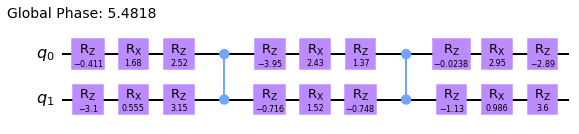

In [46]:
results = Results.load('results/state test')
d = results.decompositions[-1]
# d.refine()
d.circuit.draw(output='mpl')

In [47]:
d.refine()

'Refined to Approximate'

In [48]:
d.circuit.draw()

global phase: 0.3601
     ┌───────┐ ┌────────────┐┌───────┐   ┌─────────────┐┌────────────┐┌───────┐»
q_0: ┤ Rz(0) ├─┤ Rx(1.6752) ├┤ Rz(0) ├─■─┤ Rz(-1.4275) ├┤ Rx(2.4295) ├┤ Rz(0) ├»
     ├───────┤┌┴────────────┤├───────┤ │ └┬────────────┤├────────────┤├───────┤»
q_1: ┤ Rz(0) ├┤ Rx(0.55466) ├┤ Rz(0) ├─■──┤ Rz(2.4373) ├┤ Rx(1.5216) ├┤ Rz(0) ├»
     └───────┘└─────────────┘└───────┘    └────────────┘└────────────┘└───────┘»
«         ┌────────────┐ ┌────────────┐┌─────────────┐
«q_0: ─■──┤ Rz(1.3419) ├─┤ Rx(2.9531) ├┤ Rz(-2.8861) ├
«      │ ┌┴────────────┤┌┴────────────┤├─────────────┤
«q_1: ─■─┤ Rz(-1.8765) ├┤ Rx(0.98584) ├┤ Rz(-2.6837) ├
«        └─────────────┘└─────────────┘└─────────────┘

In [49]:
from exact_decompositions import *

In [50]:
u, angs, wires = qiskit_circ_to_jax_unitary(d.circuit)
lf = lambda a: d.unitary_loss_func(u(a))

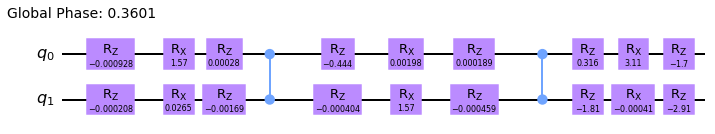

In [51]:
l_angles = lasso_angles(lf, jnp.array(angs), eps=1e-5)
replace_angles_in_circuit(d.circuit, l_angles).draw(output='mpl')

In [17]:
1.03/jnp.pi

0.3278591827693044

## 

In [91]:
test_state

array([0.+0.j        , 0.-0.70710678j, 0.+0.70710678j, 0.+0.j        ])

In [95]:
norm = -4.80349160e-01-5.18907168e-01j
comp_state = Statevector.from_instruction(d.circuit.reverse_bits()).data
comp_state

array([ 1.24426258e-05+1.04062112e-05j,  3.91323475e-01+5.88953332e-01j,
       -3.91325301e-01-5.88951966e-01j,  4.63484417e-06+1.51558266e-05j])

In [97]:
cost_overlap(comp_state, test_state)

DeviceArray(1.1920929e-07, dtype=float32)

In [39]:
cost_overlap(jnp.array([1/jnp.sqrt(2),-1/jnp.sqrt(2)]), jnp.array([1/jnp.sqrt(2),1/jnp.sqrt(2)]))

DeviceArray(1., dtype=float32)

In [29]:
qc = QuantumCircuit(3)
print(Statevector.from_instruction(qc))
print(Statevector.from_instruction(qc.reverse_bits()))

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
